In [50]:
import glob
import os
import datetime as dt
import nltk
import numpy as np
import pandas as pd

from pathlib import Path
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
# from pyspark.sql.functions import col, udf, unix_timestamp
from datetime import datetime
from textblob import TextBlob

In [51]:
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata
sentiment_i_a = SentimentIntensityAnalyzer()
from nltk.corpus import subjectivity
from nltk.sentiment.util import *

https://github.com/Drabble/TwitterSentimentAndCryptocurrencies

In [52]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tnrange, tqdm_notebook, tqdm
from matplotlib import pyplot as plt

In [53]:
currency = [
    "DOGE"
    # "BTC",
    #"ETH",
    #"USDT",
    # "XRP",
    #"BCH",
    #"ADA",
    #"BSV",
    #"LTC",
    #"LINK",
    #"BNB",
    #"EOS",
    #"TRON",
]

In [63]:
class process_tweets():

    def __init__(self, tokenizer=None, stop_words=None, stemmer=None, lemmatizer=None):
        """ 
        Initialize the class.
        """
        self.path = Path(f'{os.getcwd()}')
        self.tokenizer = tokenizer
        self.stop_words = stop_words
        self.stemmer = stemmer
        self.lemmatizer = lemmatizer

        self.df = []
        self.vocabulary = []
        self.final = []

    # Read tweets from CSV for every currency
    def read_tweets(self, curr):
        """
        Read the tweets from the CSV file.
        """
        #initialize the dataframe
        aux = []
        ret = pd.DataFrame()
        for file in glob.glob(f"{self.path}/twitter_data/*/*-{curr}*.csv"):
            # print(f"Reading {file}")
            ret = pd.concat([pd.read_csv(file)], ignore_index=True)
            ret['coin_type'] = curr
            aux.append(ret)

        self.df = pd.concat(aux, ignore_index=True)
        # Print the number of rows
        print(f"Number of rows: {len(self.df)}")


    def clean_df(self):
        """
        Since I repeted the data mining multiple times, we expect duplicate of tweets.
        Keep the latess mined as the number of followers and retweets can chage.
        """
        self.df.sort_values(by=['created_at'], ascending=True)
        self.df.drop_duplicates(subset=['tweet_id'], keep='last', ignore_index=True)

        self.df.drop(columns=['tweet_id', 'name', 'screen_name', 'mined_at', 
                              'favourite_count', 'hashtags', 
                              'status_count', 'location', 
                              'source_device', 'retweet_text'], inplace=True)


        self.df['created_at'] = pd.to_datetime(self.df['created_at'], format='%Y-%m-%d %H:%M')
        # Round time by 1h
        self.df['round_time'] = self.df['created_at'].dt.round('1h')
        self.df['round_time'] = self.df['round_time'].dt.strftime('%Y-%m-%d %H:%M')


    def clean_text(self, text):
        """
        Clean the text.
        """
        count = 0
        # Tokenize the text
        tokens = self.tokenizer.tokenize(text)
        count += len(tokens)
        # Remove stop words
        tokens = [token for token in tokens if token not in self.stop_words]
        # Case Folding
        tokens = [token.lower() for token in tokens]
        # Lemmatize the text
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
        # Add word to vocabulary
        self.vocabulary.extend(tokens)

        # Return the lemma text
        return " ".join(tokens), count

    def process_ccy(self):
        """
        Processes the currency data.
        """
        # Create a new column for text_clean and assign ""
        self.df["text_clean"] = ""

        count = 0
        # Create column for text_clean and process the text
        for index, row in self.df.iterrows():

            # Clean the text
            text_clean, words = self.clean_text(row['text'])
            count += words
            # Add the cleaned text to the dataframe
            self.df['text_clean'][index] = text_clean
        
        print(f"There are {count} words in the text")
        print(f"Number of unique words: {len(self.vocabulary)}")
    
    def drop_last(self):
        """
        Drop text and created_at columns.
        """
        self.df.drop(columns=['text', 'created_at'], inplace=True)


    def getSentiment(self, tweet) -> list:
        """
        Get the sentiment of the tweet.
        """
        analysis = TextBlob(tweet)

        return analysis.sentiment.polarity

    def set_sentiment_VADER(self):
        """
        Set the sentiment using VADER.
        """
        analyser = SentimentIntensityAnalyzer()
        compound = []
        positive = []
        negative = []
        neutral = []
        for i, tweet in enumerate(tqdm(self.df['text_clean'])):
            try:
                sentiment_sentance = analyser.polarity_scores(tweet)
                compound.append(sentiment_sentance['compound'])
                positive.append(sentiment_sentance['pos'])
                negative.append(sentiment_sentance['neg'])
                neutral.append(sentiment_sentance['neu'])
            except TypeError:
                print(f"Error in tweet {i}")

        self.df['sentiment_VADER'] = compound
        self.df['positive'] = positive
        self.df['negative'] = negative
        self.df['neutral'] = neutral

        # Print percentage of positive, negative and neutral
        print(f"Percentage of positive: {self.df['positive'].mean()}")
        print(f"Percentage of negative: {self.df['negative'].mean()}")
        print(f"Percentage of neutral: {self.df['neutral'].mean()}")


    def set_score(self):
        """
        Set the sentiment score.
        To calculate the score for each tweet, we use different variables to which we had a weight based on its importance.
        The compound column represents the sentiment of the tweets and its value is between -1 and 1.
        We also use the number of retweets, and the number of users that follow the tweet's author.
        """
        score = []
        for i, tweet in tqdm(self.df.iterrows(), total=self.df.shape[0]):
            score.append(tweet['sentiment_VADER'] * (tweet['followers_count'])) #* (tweet['retweet_count']+1))

        self.df['score'] = score

In [68]:
processed = process_tweets(RegexpTokenizer(r'\w+'), 
                           stop_words=stopwords.words('english'), 
                           stemmer=SnowballStemmer("english"), 
                           lemmatizer=WordNetLemmatizer()
                           )
# Read data and concatenate to dataframe
for curr in currency:
    processed.read_tweets(curr)

processed.clean_df()
processed.process_ccy()
processed.drop_last()

processed.set_sentiment_VADER()

# Create a dataframe with the sentiment
for curr in currency:
    processed.df['sentiment'] = processed.df['text_clean'].apply(processed.getSentiment)

processed.set_score()


###### THIS IS A DRAFT ######
# Rearange the columns 'coin_type', 'round_time', 'text_clean', 'sentiment'
# processed.df = processed.df[['coin_type', 'round_time', 'text_clean','retweet_count', 'followers_count', 'sentiment_VADER', 'positive', 'negative', 'neutral', 'sentiment', 'score']]
processed.df = processed.df[['round_time', 'sentiment_VADER', 'positive', 'negative', 'neutral', 'sentiment', 'score']]

# Rename the column round_time to date
processed.df.rename(columns={'round_time': 'date'}, inplace=True)

Number of rows: 66251


C:\Users\paulc\AppData\Local\Temp/ipykernel_28268/1920121307.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['text_clean'][index] = text_clean


There are 1398224 words in the text
Number of unique words: 1134537


100%|██████████| 66251/66251 [00:05<00:00, 11315.15it/s]


Percentage of positive: 0.10946450619613289
Percentage of negative: 0.020167831428959566
Percentage of neutral: 0.87036877933918


100%|██████████| 66251/66251 [00:03<00:00, 19571.17it/s]


In [69]:
# Print hean of Positive column
print(processed.df.head())

               date  sentiment_VADER  positive  negative  neutral  sentiment  \
0  2022-01-14 08:00           0.7906     0.412       0.0    0.588       0.65   
1  2022-01-14 08:00           0.6369     0.219       0.0    0.781       1.00   
2  2022-01-14 08:00           0.0000     0.000       0.0    1.000       0.00   
3  2022-01-14 08:00           0.6249     0.272       0.0    0.728       0.80   
4  2022-01-14 08:00           0.0000     0.000       0.0    1.000       0.00   

      score  
0  494.9156  
1  223.5519  
2    0.0000  
3  391.1874  
4    0.0000  


### Truncating dataframe by hour and then grouping them by hour

In [70]:
# Sort the dataframe by date
processed.df.sort_values(by=['date'], ascending=True, inplace=True)

# Print the first and last element in date column 
print(processed.df['date'].iloc[0])
print(processed.df['date'].iloc[-1])

2022-01-13 17:00
2022-01-14 22:00


In [77]:
###### THIS IS A DRAFT ######


# Create hourly dataframe to get the average sentiment, positive, negative, neutral, score
hour_df = pd.DataFrame(columns=['date', 'positive', 'negative', 'neutral', 'score'])

for hour in processed.df['date'].unique():
    pos = processed.df[processed.df['date'] == hour]['positive'].mean()
    neg = processed.df[processed.df['date'] == hour]['negative'].mean()
    neu = processed.df[processed.df['date'] == hour]['neutral'].mean()
    score = processed.df[processed.df['date'] == hour]['score'].mean()
    hour_df.loc[len(hour_df)] = [hour, pos, neg, neu, score]

print(hour_df.head())

               date  positive  negative   neutral       score
0  2022-01-13 17:00  0.099517  0.037228  0.863284  232.456765
1  2022-01-13 18:00  0.088475  0.033548  0.877998  295.018028
2  2022-01-13 19:00  0.094921  0.032796  0.872287  216.354902
3  2022-01-13 20:00  0.091648  0.026843  0.881507  378.167873
4  2022-01-13 21:00  0.099684  0.024527  0.875786  217.496336


In [9]:
# Create hourly_sentiment_df to store the sentiment data for each hour
hourly_score_df = pd.DataFrame(columns=['date', 'score'])

# for loop to get the mean of score for each hour
for hour in processed.df['date'].unique():
    score = processed.df[processed.df['date'] == hour]['score']
    mean_score= score.mean()

    # Create a dataframe with the mean sentiment for each hour
    hourly_score_df = hourly_score_df.append({'date': hour, 'score': mean_score}, ignore_index=True)

In [10]:
# Print first and last element in hourly_sentiment_df
print(hourly_score_df.iloc[0])
print(hourly_score_df.iloc[-1])

date     2022-01-13 17:00
score          232.456765
Name: 0, dtype: object
date     2022-01-14 22:00
score         1254.336807
Name: 29, dtype: object


### Read Market Prices #COIN

In [78]:
doge_price_data = pd.read_csv(f"{processed.path}/DOGE_price.csv")
doge_price_data.rename(columns={'time': 'date'}, inplace=True)
doge_price_data.date = doge_price_data.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d %H:%M'))

In [82]:
###### THIS IS A DRAFT ######

merged_df = pd.merge(hour_df, doge_price_data, on='date', how='inner')
# # Drop the 'Unamed: 0' column
merged_df.drop(columns=['Unnamed: 0'], inplace=True)
merged_df.fillna(0, inplace=True)

# Sort the dataframe by date ascending
merged_df.sort_values(by=['date'], ascending=True, inplace=True)

print(merged_df)

                date  positive  negative   neutral        score   close  \
0   2022-01-13 17:00  0.099517  0.037228  0.863284   232.456765  0.1629   
1   2022-01-13 18:00  0.088475  0.033548  0.877998   295.018028  0.1627   
2   2022-01-13 19:00  0.094921  0.032796  0.872287   216.354902  0.1630   
3   2022-01-13 20:00  0.091648  0.026843  0.881507   378.167873  0.1660   
4   2022-01-13 21:00  0.099684  0.024527  0.875786   217.496336  0.1707   
5   2022-01-13 22:00  0.084185  0.031894  0.883919   191.059769  0.1671   
6   2022-01-13 23:00  0.116418  0.026720  0.856872   217.261591  0.1717   
7   2022-01-14 00:00  0.099455  0.025557  0.874990   113.171744  0.1781   
8   2022-01-14 01:00  0.090157  0.028529  0.881309   163.900420  0.1764   
9   2022-01-14 02:00  0.090497  0.026574  0.882924   258.128379  0.1775   
10  2022-01-14 03:00  0.088859  0.026163  0.884984   218.279833  0.1759   
11  2022-01-14 04:00  0.095631  0.030806  0.873566   196.182004  0.1897   
12  2022-01-14 05:00  0.1

In [83]:
# Save the dataframe to csv
merged_df.to_csv(f"{processed.path}/hour_df.csv", index=False)

In [14]:
# Merge the dataframes hourly_score_df and doge_price_data on date column
# merged_df = pd.merge(hourly_score_df, doge_price_data, on='date', how='outer')
# # Drop the 'Unamed: 0' column
# merged_df.drop(columns=['Unnamed: 0'], inplace=True)
# merged_df.fillna(0, inplace=True)

# print(merged_df)

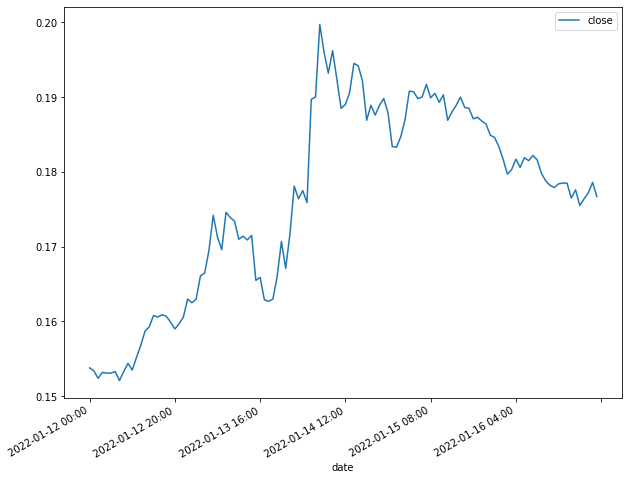

In [15]:
# Plot the doge_price_data for date and close columns
doge_price_data.plot(x='date', y=['close'], figsize=(10, 8))
plt.gcf().autofmt_xdate()
plt.show()

## Plotting the score

In [16]:
# Plot the score for each hour
# fig, ax = plt.subplots(figsize=(20, 10))
# ax.set_title('Sentiment score for each hour', fontsize=20)
# ax.tick_params(labelsize=15)
# ax2 = ax.twinx()
# ax.plot(doge_price_data['date'], merged_df['score'], color='green', label='score')
# # ax2.plot(merged_df['date'], merged_df['close'], color='blue', label='price')

# # ax.plot(hourly_score_df['date'], hourly_score_df['score'], color='blue', linewidth=2)
# ax2.plot(doge_price_data['date'], doge_price_data['close'], color='blue', linewidth=2)

# # ax.set_ylabel('Sentiment score', fontsize=15, color='green')
# ax2.set_ylabel('DOGE price', fontsize=15, color='blue')
# plt.show()

### The following is sentiment not score

In [17]:
hourly_sentiment_df = pd.DataFrame()

# for loop to get the mean of sentiment for each hour
for hour in processed.df['date'].unique():
    # Get the sentiment for each hour
    sentiment = processed.df[processed.df['date'] == hour]['sentiment_VADER']
    mean_sentiment = sentiment.mean()

    # Create a dataframe with the mean sentiment for each hour
    hourly_sentiment_df = hourly_sentiment_df.append({'date': hour, 'sentiment': mean_sentiment}, ignore_index=True)

print(f"Head of the hourly sentiment dataframe: {hourly_sentiment_df.head()}")
print(f"Number of rows: {len(hourly_sentiment_df)}")

Head of the hourly sentiment dataframe:                date  sentiment
0  2022-01-13 17:00   0.206676
1  2022-01-13 18:00   0.175150
2  2022-01-13 19:00   0.187216
3  2022-01-13 20:00   0.190882
4  2022-01-13 21:00   0.197966
Number of rows: 30


### Process Market Price for #COINS to the same format

In [18]:
# from datetime import datetime

# ret = []
# for curr in currency:
#     for file in glob.glob(f"{processed.path}/market-price_data/{curr}*.csv"):
#         ret = pd.concat([pd.read_csv(file)], ignore_index=True)
#         ret['coin_type'] = curr

# # Rename column TIME to date
# ret.rename(columns={'TIME': 'date'}, inplace=True)
# ret.date = ret.date.apply(lambda x: datetime.strptime(x, '%d-%m-%y %H:%M:%S').strftime('%Y-%m-%d %H:%M'))

# # Drop columns that are not needed PAIR, TIME
# ret.drop(columns=['PAIR'], inplace=True)

# # Sort the dataframe by date ascending
# ret.sort_values(by=['date'], ascending=True, inplace=True) 
# # Rearange columns to match the dataframe
# doge_market_data = ret[['coin_type', 'date', 'BID', 'ASK']]

In [49]:
# Print number of rows in doge_price_data
print(len(doge_price_data))


120


In [81]:
merged_df = pd.merge(hourly_sentiment_df, doge_price_data, on='date', how='outer')
# # Drop the 'Unamed: 0' column
merged_df.drop(columns=['Unnamed: 0'], inplace=True)
merged_df.fillna(0, inplace=True)

# Sort the dataframe by date ascending
merged_df.sort_values(by=['date'], ascending=True, inplace=True)

print(merged_df)

                date  sentiment   close coin_type
0   2022-01-13 17:00   0.206676  0.1629      DOGE
1   2022-01-13 18:00   0.175150  0.1627      DOGE
2   2022-01-13 19:00   0.187216  0.1630      DOGE
3   2022-01-13 20:00   0.190882  0.1660      DOGE
4   2022-01-13 21:00   0.197966  0.1707      DOGE
5   2022-01-13 22:00   0.161976  0.1671      DOGE
6   2022-01-13 23:00   0.257201  0.1717      DOGE
7   2022-01-14 00:00   0.217028  0.1781      DOGE
8   2022-01-14 01:00   0.167166  0.1764      DOGE
9   2022-01-14 02:00   0.176007  0.1775      DOGE
10  2022-01-14 03:00   0.191235  0.1759      DOGE
11  2022-01-14 04:00   0.187398  0.1897      DOGE
12  2022-01-14 05:00   0.193311  0.1900      DOGE
13  2022-01-14 06:00   0.200559  0.1997      DOGE
14  2022-01-14 07:00   0.216890  0.1960      DOGE
15  2022-01-14 08:00   0.245467  0.1932      DOGE
16  2022-01-14 09:00   0.256795  0.1962      DOGE
17  2022-01-14 10:00   0.261617  0.1924      DOGE
18  2022-01-14 11:00   0.245929  0.1885      DOGE


In [47]:
# count number of rows in merged_df
print(f"Number of rows: {len(merged_df)}")

Number of rows: 120


In [46]:
# Save the dataframe to a csv file
merged_df.to_csv(f"{processed.path}/merged_df.csv", index=False)

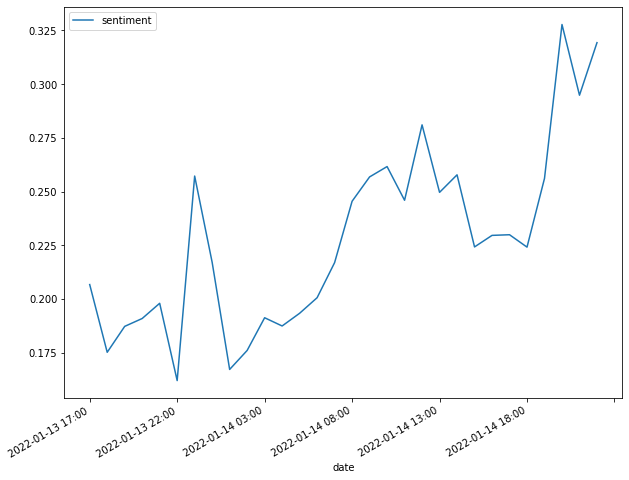

In [20]:
# Plot the hour sentiment dataframe
hourly_sentiment_df.plot(x='date', y='sentiment', figsize=(10, 8))
plt.gcf().autofmt_xdate()
plt.show()

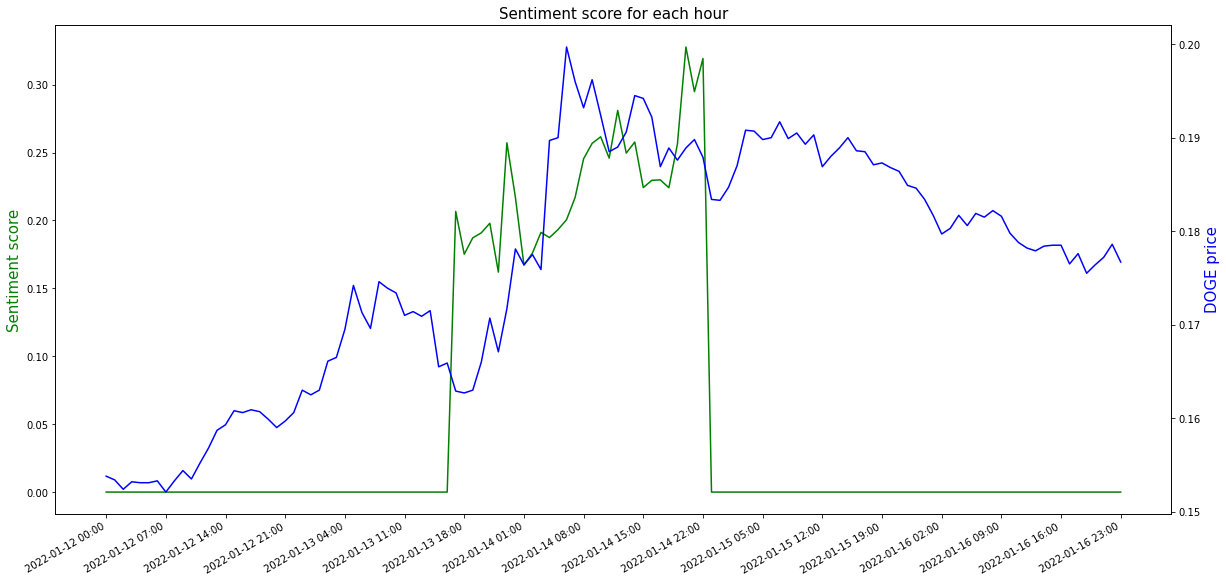

In [21]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.set_title('Sentiment score for each hour', fontsize=15)
ax.tick_params(labelsize=10)
# ax.locator_params(axis='x', nbins=1)

ax2 = ax.twinx()
ax.plot(doge_price_data['date'], merged_df['sentiment'], color='green')
ax2.plot(doge_price_data['date'], doge_price_data['close'], color='blue')

ax.set_ylabel('Sentiment score', fontsize=15, color='green')
ax2.set_ylabel('DOGE price', fontsize=15, color='blue')

ax.set_xticks(ax.get_xticks()[::7])

plt.gcf().autofmt_xdate()
plt.show()


### Cross-Correllation analysis
Applying a correlation on the series (tweets' scores and crypto currency) is not enough. That's why we need cross-correlation. The difference is that cross-correlation adds a lag which permit to shift one of the timeseries left or right to find, maybe, a better correlation. This is coherent with our problem as the currency changes come after the tweets' sentiments. So we are fully allowed to operate it.


We can test our correlation hypothesis using the Pandas corr() method, which computes a Pearson correlation coefficient for each column in the dataframe against each other column.

This Stackoverflow answer gives very useful details about correlating with time series. https://stackoverflow.com/questions/6467832/how-to-get-the-correlation-between-two-timeseries-using-pandas

In [22]:
# Define the cross-correlation function

def crosscorr(datax, datay, lag=0, method="pearson"):
    """ Lag-N cross correlation. 
    Parameters
    —------—
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    —------—
    crosscorr : float
    """
    return datax.corr(datay.shift(lag), method=method)

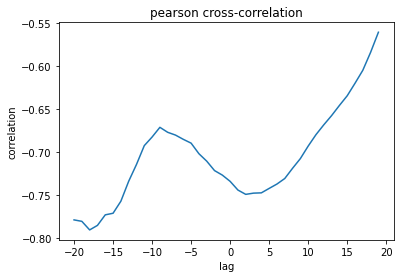

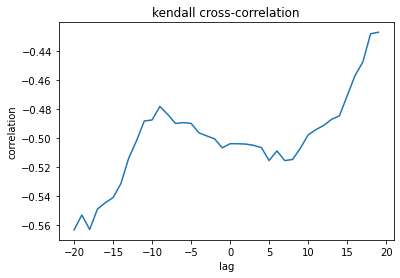

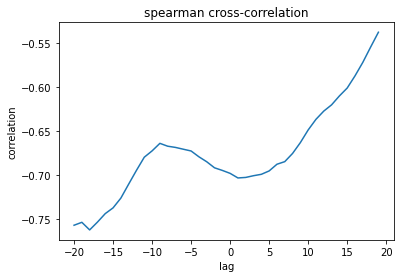

In [23]:
xcov = [crosscorr(merged_df['sentiment'], doge_price_data['close'], lag=i, method="pearson") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("pearson cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(merged_df['sentiment'], doge_price_data['close'], lag=i, method="kendall") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("kendall cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(merged_df['sentiment'], doge_price_data['close'], lag=i, method="spearman") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("spearman cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

### Normalize data

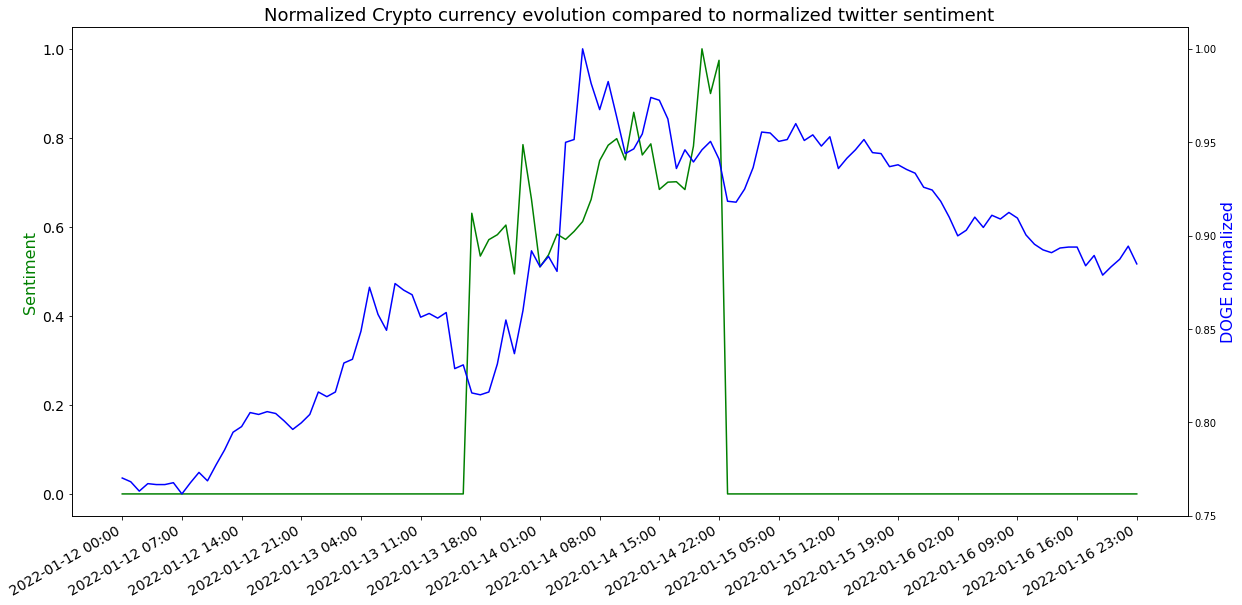

In [24]:
tweets_grouped = merged_df['sentiment'] / max(merged_df['sentiment'].max(), abs(merged_df['sentiment'].min()))
crypto_usd_grouped = doge_price_data['close'] / max(doge_price_data['close'].max(), abs(doge_price_data['close'].min()))

fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Normalized Crypto currency evolution compared to normalized twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(doge_price_data['date'], tweets_grouped, 'g-')
ax2.plot_date(doge_price_data['date'], crypto_usd_grouped, 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax2.set_ylabel("DOGE normalized", color='b', fontsize=16)

ax1.set_xticks(ax1.get_xticks()[::7])

plt.gcf().autofmt_xdate()
plt.show()

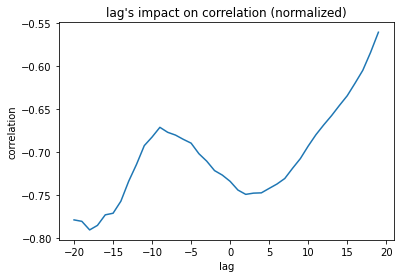

In [25]:
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i) for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("lag's impact on correlation (normalized)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

In [26]:
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

import scipy.stats as stats

In [27]:
num_states = 4
initial_state_logits = tf.zeros([num_states]) # uniform distribution

daily_change_prob = 0.05
transition_probs = tf.fill([num_states, num_states],
                           daily_change_prob / (num_states - 1))
transition_probs = tf.linalg.set_diag(transition_probs,
                                      tf.fill([num_states],
                                              1 - daily_change_prob))

print("Initial state logits:\n{}".format(initial_state_logits))
print("Transition matrix:\n{}".format(transition_probs))

Initial state logits:
[0. 0. 0. 0.]
Transition matrix:
[[0.95       0.01666667 0.01666667 0.01666667]
 [0.01666667 0.95       0.01666667 0.01666667]
 [0.01666667 0.01666667 0.95       0.01666667]
 [0.01666667 0.01666667 0.01666667 0.95      ]]


Next, we build a tfd.HiddenMarkovModel distribution, using a trainable variable to represent the rates associated with each system state. We parameterize the rates in log-space to ensure they are positive-valued.

In [28]:
observed_sentiment = merged_df['sentiment']
observed_sentiment = tf.convert_to_tensor(observed_sentiment, dtype=tf.float32)


# Define variable to represent the unknown log rates.
trainable_log_rates = tf.Variable(
  tf.math.log(tf.reduce_mean(observed_sentiment)) +
  tf.random.stateless_normal([num_states], seed=(42, 42)),
  name='log_rates')

hmm = tfd.HiddenMarkovModel(
  initial_distribution=tfd.Categorical(
      logits=initial_state_logits),
  transition_distribution=tfd.Categorical(probs=transition_probs),
  observation_distribution=tfd.Poisson(log_rate=trainable_log_rates),
  num_steps=len(observed_sentiment))

Finally, we define the model's total log density, including a weakly-informative LogNormal prior on the rates, and run an optimizer to compute the maximum a posteriori (MAP) fit to the observed count data.

Text(0, 0.5, 'Negative log marginal likelihood')

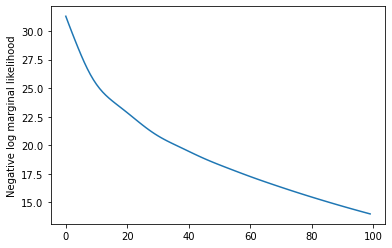

In [29]:
rate_prior = tfd.LogNormal(5, 5)

def log_prob():
 return (tf.reduce_sum(rate_prior.log_prob(tf.math.exp(trainable_log_rates))) +
         hmm.log_prob(observed_sentiment))

losses = tfp.math.minimize(
    lambda: -log_prob(),
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    num_steps=100)
plt.plot(losses)
plt.ylabel('Negative log marginal likelihood')

In [30]:
# This is to check the accuracy of the model.

rates = tf.exp(trainable_log_rates)
# print("Inferred rates: {}".format(rates))
# print("True rates: {}".format(merged_df['sentiment']))

### Recovering the state trajectory
Now that we've fit the model, we might want to reconstruct which state the model believes the system was in at each timestep.

This is a posterior inference task: given the observed counts  x1:T  and model parameters (rates)  λ , we want to infer the sequence of discrete latent variables, following the posterior distribution  p(z1:T|x1:T,λ) . In a hidden Markov model, we can efficiently compute marginals and other properties of this distribution using standard message-passing algorithms. In particular, the posterior_marginals method will efficiently compute (using the forward-backward algorithm) the marginal probability distribution  p(Zt=zt|x1:T)  over the discrete latent state  Zt  at each timestep  t .

In [31]:
# Runs forward-backward algorithm to compute marginal posteriors.
posterior_dists = hmm.posterior_marginals(observed_sentiment)
posterior_probs = posterior_dists.probs_parameter().numpy()

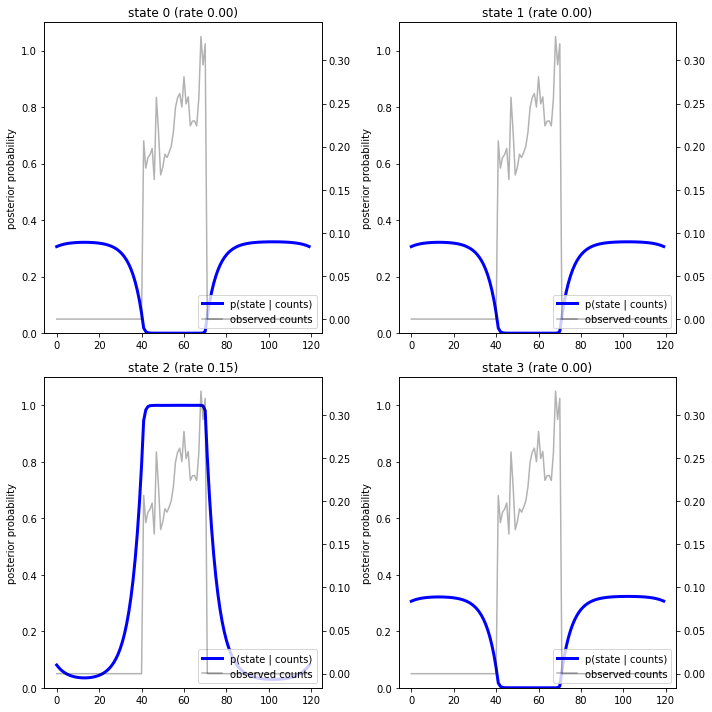

In [32]:
def plot_state_posterior(ax, state_posterior_probs, title):
    ln1 = ax.plot(state_posterior_probs, c='blue', lw=3, label='p(state | counts)')
    ax.set_ylim(0., 1.1)
    ax.set_ylabel('posterior probability')
    ax2 = ax.twinx()
    ln2 = ax2.plot(observed_sentiment, c='black', alpha=0.3, label='observed counts')
    ax2.set_title(title)
    ax2.set_xlabel("time")
    lns = ln1+ln2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=4)
    ax.grid(True, color='white')
    ax2.grid(False)

fig = plt.figure(figsize=(10, 10))
plot_state_posterior(fig.add_subplot(2, 2, 1),
                     posterior_probs[:, 0],
                     title="state 0 (rate {:.2f})".format(rates[0]))
plot_state_posterior(fig.add_subplot(2, 2, 2),
                     posterior_probs[:, 1],
                     title="state 1 (rate {:.2f})".format(rates[1]))
plot_state_posterior(fig.add_subplot(2, 2, 3),
                     posterior_probs[:, 2],
                     title="state 2 (rate {:.2f})".format(rates[2]))
plot_state_posterior(fig.add_subplot(2, 2, 4),
                     posterior_probs[:, 3],
                     title="state 3 (rate {:.2f})".format(rates[3]))
plt.tight_layout()

In this (simple) case, we see that the model is usually quite confident: at most timesteps it assigns essentially all probability mass to a single one of the four states. Luckily, the explanations look reasonable!

We can also visualize this posterior in terms of the rate associated with the most likely latent state at each timestep, condensing the probabilistic posterior into a single explanation:

In [33]:
most_probable_states = hmm.posterior_mode(observed_sentiment)
most_probable_rates = tf.gather(rates, most_probable_states)

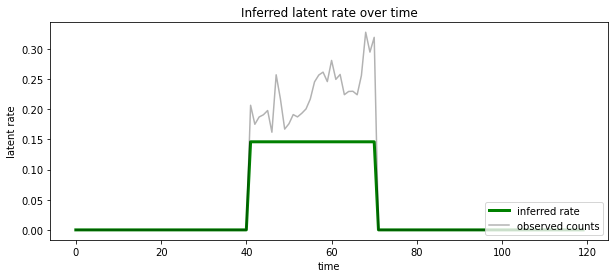

In [34]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(most_probable_rates, c='green', lw=3, label='inferred rate')
ax.plot(observed_sentiment, c='black', alpha=0.3, label='observed counts')
ax.set_ylabel("latent rate")
ax.set_xlabel("time")
ax.set_title("Inferred latent rate over time")
ax.legend(loc=4)

### When we don't know the number of states 

We can view this as a case of [Bayesian model selection](http://alumni.media.mit.edu/~tpminka/statlearn/demo/): we have a set of candidate models, each with a different number of latent states, and we want to choose the one that is most likely to have generated the observed data. To do this, we compute the marginal likelihood of the data under each model (we could also add a prior on the models themselves, but that won't be necessary in this analysis; the [Bayesian Occam's razor](https://www.cs.princeton.edu/courses/archive/fall09/cos597A/papers/MacKay2003-Ch28.pdf) turns out to be sufficient to encode a preference towards simpler models).

Unfortunately, the true marginal likelihood, which integrates over both the discrete states $z_{1:T}$ and the (vector of) rate parameters $\lambda$, $$p(x_{1:T}) = \int p(x_{1:T}, z_{1:T}, \lambda) dz d\lambda,$$ is not tractable for this model. For convenience, we'll approximate it using a so-called "[empirical Bayes](https://www.cs.ubc.ca/~schmidtm/Courses/540-W16/L19.pdf)" or "type II maximum likelihood" estimate: instead of fully integrating out the (unknown) rate parameters $\lambda$ associated with each system state, we'll optimize over their values:

$$\tilde{p}(x_{1:T}) = \max_\lambda \int p(x_{1:T}, z_{1:T}, \lambda) dz$$

This approximation may overfit, i.e., it will prefer more complex models than the true marginal likelihood would. We could consider more faithful approximations, e.g., optimizing a variational lower bound, or using a Monte Carlo estimator such as [annealed importance sampling](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/sample_annealed_importance_chain); these are (sadly) beyond the scope of this notebook. (For more on Bayesian model selection and approximations, chapter 7 of the excellent [Machine Learning: a Probabilistic Perspective
](https://www.cs.ubc.ca/~murphyk/MLbook/) is a good reference.)

In principle, we could do this model comparison simply by rerunning the optimization above many times with different values of `num_states`, but that would be a lot of work. Here we'll show how to consider multiple models in parallel, using TFP's `batch_shape` mechanism for vectorization.

Transition matrix and initial state prior: rather than building a single model description, now we'll build a batch of transition matrices and prior logits, one for each candidate model up to max_num_states. For easy batching we'll need to ensure that all computations have the same 'shape': this must correspond to the dimensions of the largest model we'll fit. To handle smaller models, we can 'embed' their descriptions in the topmost dimensions of the state space, effectively treating the remaining dimensions as dummy states that are never used.

In [35]:
max_num_states = 10

def build_latent_state(num_states, max_num_states, daily_change_prob=0.05):

    # Give probability exp(-100) ~= 0 to states outside of the current model.
    active_states_mask = tf.concat([tf.ones([num_states]),
                                    tf.zeros([max_num_states - num_states])],
                                    axis=0)
    initial_state_logits = -100. * (1 - active_states_mask)

    # Build a transition matrix that transitions only within the current
    # `num_states` states.
    transition_probs = tf.fill([num_states, num_states],
                                0. if num_states == 1
                                else daily_change_prob / (num_states - 1))  
    padded_transition_probs = tf.eye(max_num_states) + tf.pad(
        tf.linalg.set_diag(transition_probs,
                            tf.fill([num_states], - daily_change_prob)),
        paddings=[(0, max_num_states - num_states),
                    (0, max_num_states - num_states)])

    return initial_state_logits, padded_transition_probs

# For each candidate model, build the initial state prior and transition matrix.
batch_initial_state_logits = []
batch_transition_probs = []
for num_states in range(1, max_num_states+1):
  initial_state_logits, transition_probs = build_latent_state(
      num_states=num_states,
      max_num_states=max_num_states)
  batch_initial_state_logits.append(initial_state_logits)
  batch_transition_probs.append(transition_probs)

batch_initial_state_logits = tf.stack(batch_initial_state_logits)
batch_transition_probs = tf.stack(batch_transition_probs)
print("Shape of initial_state_logits: {}".format(batch_initial_state_logits.shape))
print("Shape of transition probs: {}".format(batch_transition_probs.shape))
print("Example initial state logits for num_states==3:\n{}".format(batch_initial_state_logits[2, :]))
print("Example transition_probs for num_states==3:\n{}".format(batch_transition_probs[2, :, :]))

Shape of initial_state_logits: (10, 10)
Shape of transition probs: (10, 10, 10)
Example initial state logits for num_states==3:
[  -0.   -0.   -0. -100. -100. -100. -100. -100. -100. -100.]
Example transition_probs for num_states==3:
[[0.95  0.025 0.025 0.    0.    0.    0.    0.    0.    0.   ]
 [0.025 0.95  0.025 0.    0.    0.    0.    0.    0.    0.   ]
 [0.025 0.025 0.95  0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    1.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    1.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    1.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    1.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    1.   ]]


In [36]:
trainable_log_rates = tf.Variable(
    tf.fill([batch_initial_state_logits.shape[0], max_num_states],
            tf.math.log(tf.reduce_mean(observed_sentiment))) + 
     tf.random.stateless_normal([1, max_num_states], seed=(42, 42)),
     name='log_rates')
    
hmm = tfd.HiddenMarkovModel(
  initial_distribution=tfd.Categorical(
      logits=batch_initial_state_logits),
  transition_distribution=tfd.Categorical(probs=batch_transition_probs),
  observation_distribution=tfd.Poisson(log_rate=trainable_log_rates),
  num_steps=len(observed_sentiment))
print("Defined HMM with batch shape: {}".format(hmm.batch_shape))

Defined HMM with batch shape: (10,)


In [37]:
rate_prior = tfd.LogNormal(5, 5)

def log_prob():
  prior_lps = rate_prior.log_prob(tf.math.exp(trainable_log_rates))
  prior_lp = tf.stack(
      [tf.reduce_sum(prior_lps[i, :i+1]) for i in range(max_num_states)])
  return prior_lp + hmm.log_prob(observed_sentiment)

Text(0, 0.5, 'Negative log marginal likelihood')

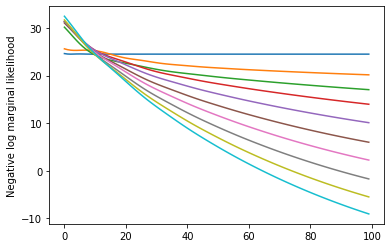

In [38]:
losses = tfp.math.minimize(
    lambda: -log_prob(),
    optimizer=tf.optimizers.Adam(0.1),
    num_steps=100)
plt.plot(losses)
plt.ylabel('Negative log marginal likelihood')

Text(0.5, 1.0, 'Model selection on latent states')

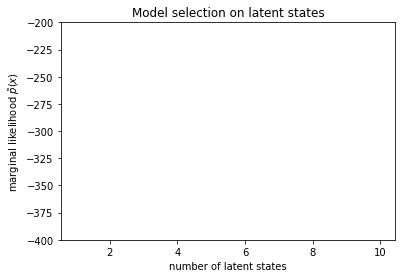

In [39]:
num_states = np.arange(1, max_num_states+1)
plt.plot(num_states, -losses[-1])
plt.ylim([-400, -200])
plt.ylabel("marginal likelihood $\\tilde{p}(x)$")
plt.xlabel("number of latent states")
plt.title("Model selection on latent states")

In [40]:
rates = tf.exp(trainable_log_rates)
for i, learned_model_rates in enumerate(rates):
  print("rates for {}-state model: {}".format(i+1, learned_model_rates[:i+1]))

rates for 1-state model: [0.05120172]
rates for 2-state model: [2.81686589e-05 1.13163896e-01]
rates for 3-state model: [6.525263e-05 6.532330e-05 1.369766e-01]
rates for 4-state model: [6.2442356e-05 6.2858919e-05 1.4610523e-01 4.9232025e-05]
rates for 5-state model: [3.1913245e-05 3.2220953e-05 1.4891914e-01 2.7034690e-05 2.8610368e-05]
rates for 6-state model: [1.9960953e-05 2.0184078e-05 1.5062460e-01 1.8066510e-05 1.7807766e-05
 1.0557556e-05]
rates for 7-state model: [1.6085598e-05 1.6268817e-05 1.5180030e-01 1.5123491e-05 1.4366261e-05
 8.6915015e-06 1.1686006e-05]
rates for 8-state model: [1.35247665e-05 1.36819735e-05 1.52669534e-01 1.34396487e-05
 1.20894738e-05 7.43789406e-06 9.88475313e-06 5.55363476e-06]
rates for 9-state model: [1.22619977e-05 1.24100052e-05 1.53321132e-01 1.25645556e-05
 1.09591465e-05 6.81494976e-06 8.99011684e-06 5.13708073e-06
 6.79042705e-06]
rates for 10-state model: [1.1602541e-05 1.1746084e-05 1.5387043e-01 1.1970697e-05 1.0364755e-05
 6.4883070e-

In [41]:
most_probable_states = hmm.posterior_mode(observed_sentiment)

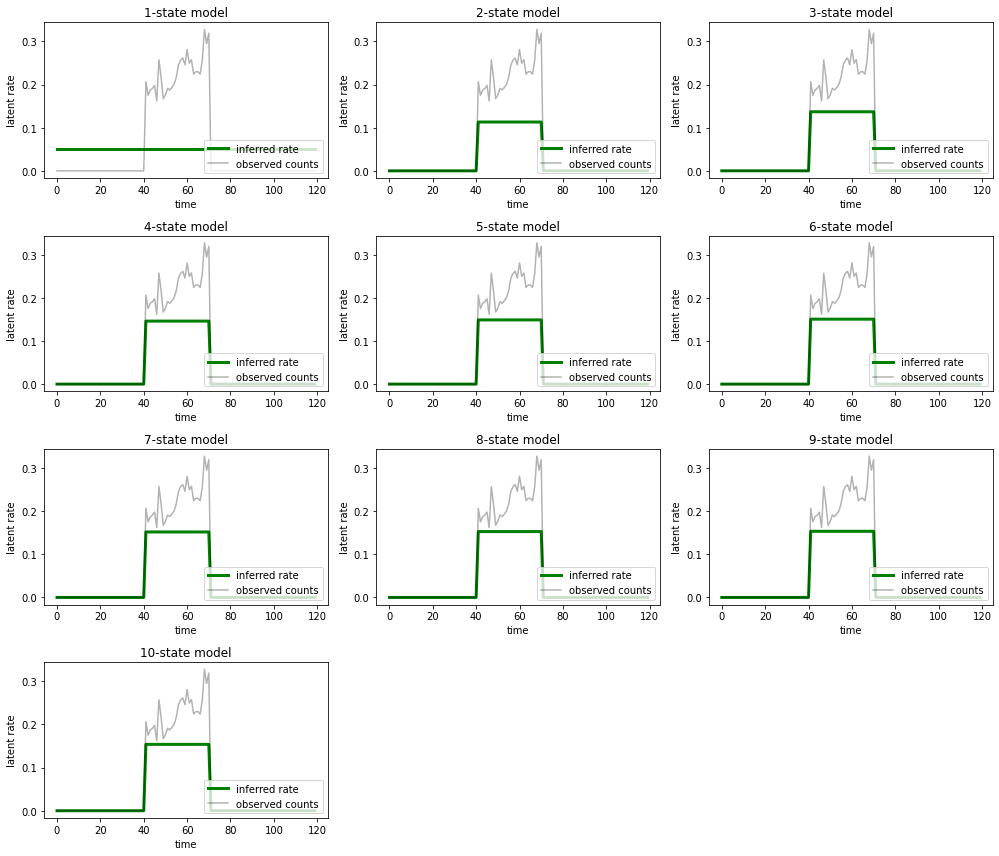

In [42]:
fig = plt.figure(figsize=(14, 12))
for i, learned_model_rates in enumerate(rates):
  ax = fig.add_subplot(4, 3, i+1)
  ax.plot(tf.gather(learned_model_rates, most_probable_states[i]), c='green', lw=3, label='inferred rate')
  ax.plot(observed_sentiment, c='black', alpha=0.3, label='observed counts')
  ax.set_ylabel("latent rate")
  ax.set_xlabel("time")
  ax.set_title("{}-state model".format(i+1))
  ax.legend(loc=4)
plt.tight_layout()

### Apply the PELT algorithm to the complete data set

In [43]:
import ruptures as rpt

In [44]:
merged_df = pd.merge(hourly_sentiment_df, doge_price_data, on='date', how='outer')
# # Drop the 'Unamed: 0' column
merged_df.drop(columns=['Unnamed: 0'], inplace=True)
merged_df.fillna(0, inplace=True)

print(merged_df.head())


               date  sentiment   close coin_type
0  2022-01-13 17:00   0.206676  0.1629      DOGE
1  2022-01-13 18:00   0.175150  0.1627      DOGE
2  2022-01-13 19:00   0.187216  0.1630      DOGE
3  2022-01-13 20:00   0.190882  0.1660      DOGE
4  2022-01-13 21:00   0.197966  0.1707      DOGE


https://techrando.com/2019/08/14/a-brief-introduction-to-change-point-detection-using-python/

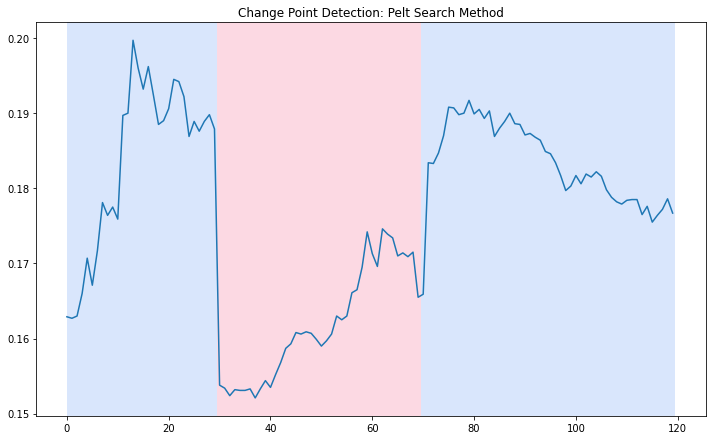

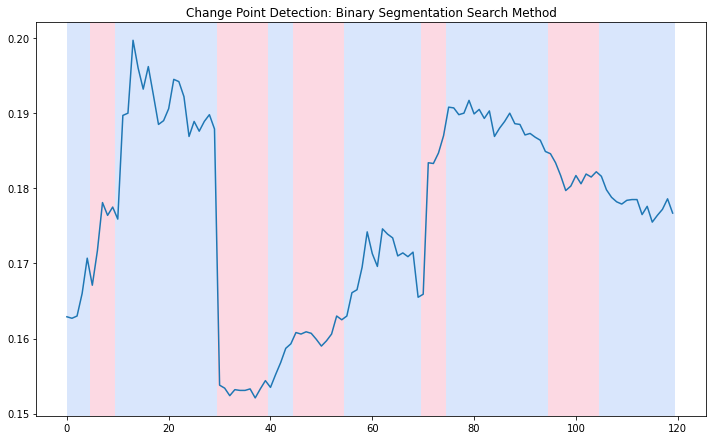

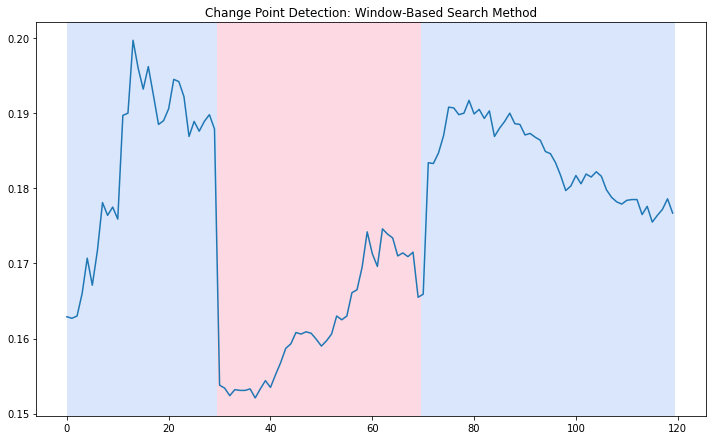

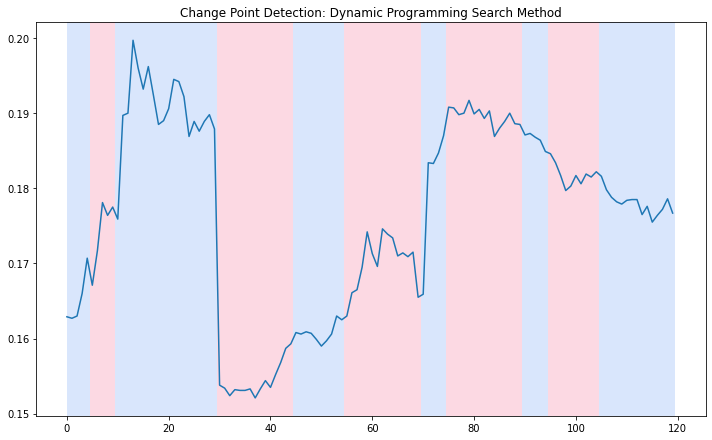

In [45]:
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    api: API that we're connected to
    series_ID: string. Name of the series that we want to pull from the EIA API
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    df = pd.DataFrame(series_search)
    return df

###############################################################################

merged_df.rename(columns={'date':'Date'}, inplace=True)
# Create a copy of merged_df to price_df
price_df = merged_df.copy()



#Convert the time series values to a numpy 1D array
points=np.array(price_df['close'])
    
#RUPTURES PACKAGE
#Changepoint detection with the Pelt search method
model="rbf"
algo = rpt.Pelt(model=model).fit(points)
result = algo.predict(pen=10)
rpt.display(points, result, figsize=(10, 6))
plt.title('Change Point Detection: Pelt Search Method')
plt.show()  
    
#Changepoint detection with the Binary Segmentation search method
model = "l2"  
algo = rpt.Binseg(model=model).fit(points)
my_bkps = algo.predict(n_bkps=10)
# show results
rpt.show.display(points, my_bkps, figsize=(10, 6))
plt.title('Change Point Detection: Binary Segmentation Search Method')
plt.show()
    
#Changepoint detection with window-based search method
model = "l2"  
algo = rpt.Window(width=40, model=model).fit(points)
my_bkps = algo.predict(n_bkps=10)
rpt.show.display(points, my_bkps, figsize=(10, 6))
plt.title('Change Point Detection: Window-Based Search Method')
plt.show()
    
#Changepoint detection with dynamic programming search method
model = "l1"  
algo = rpt.Dynp(model=model, min_size=3, jump=5).fit(points)
my_bkps = algo.predict(n_bkps=10)
rpt.show.display(points, my_bkps, figsize=(10, 6))
plt.title('Change Point Detection: Dynamic Programming Search Method')
plt.show()

In [ ]:
# Autocorrelation function (temporal auto correlation)
# Pearson correlation coefficient